## Week 3: Linear systems

In [1]:
using LaTeXStrings
using LinearAlgebra
using Plots
using Polynomials
import Random

### <font color='green'>Interpolation and approximation</font>

#### <font color='orange'>[Exercise 1]</font> Least squares approximation

The objective of this exercise is to approximate some given data `x`, `y` using a
polynomial of a given degree,
potentially much lower than the number of data points.

1. Without using any library,
   write a function `polyfit(x, y, d)` which,
   given data points
   $
       (x_1, y_1), \dotsc, (x_N, y_N)
   $
   and an integer $0 \leq d \leq N-1$,
   calculates the unique polynomial $p \in \mathbb R[x]$ of degree at most $d$ minimizing the total error

   $$
       E := \frac{1}{2} \sum_{n=0}^{N} \bigl\lvert p(x_n) - y_n \bigr\rvert^2.
   $$
   Your function should return a vector containing the $d+1$ coefficients of $p$,
   starting from the constant term.
   <details>
       <summary>
           <em><font color='gray'>Hint (click to display)</font></em>
       </summary>

   Within the function, you can proceed as follows.
   First, create the following matrix and vector:
   $$
       \mathbf{A} =
       \begin{pmatrix}
           1 & x_0 & \dots & x_0^d \\
           \vdots & \vdots & & \vdots \\
           1 & x_{N} & \dots & x_N^d
       \end{pmatrix},
       \qquad
       \mathbf{b} =
       \begin{pmatrix}
           y_0 \\
           \vdots \\
           y_N
       \end{pmatrix}.
   $$
   Note that the error $E$ rewrites as follows:
   $$
   E(\boldsymbol \alpha) = \frac{1}{2} \bigl\lVert \mathsf A \boldsymbol \alpha - \boldsymbol b \bigr\rVert^2,
   $$
   where $\boldsymbol \alpha$ is a vector containing the coefficients
   of the polynomial, in order of increasing degree, and $\lVert \cdot \rVert$
   is the Euclidean norm.
   In other words, the function $E$ is a quadratic function of the
   vector of coefficients of the polynomial.
   Writing $\nabla E(\boldsymbol \alpha) = 0$ leads to the so-called **normal equations**:
   $$
       \mathsf{A}^\top \mathsf{A} \boldsymbol{\alpha} = \mathsf{A}^\top \mathbf{b}.
   $$
   This is a linear system with a square invertible matrix on the left-hand side,
   which can be solved using the backslash operator `\`;
   in fact you can write just `A\b` instead of `(A'A)\(A'b)`,
   because the operator `\` performs a least squares approximation by default.
   </details>

In [2]:
function polyfit(x, y, d)
    ### BEGIN SOLUTION
    A = (^).(x, transpose(0:d))
    return A\y
    ### END SOLUTION
end;

In [3]:
n = 10 ; x = 1:n ; Random.seed!(2025); y = randn(n)
@assert polyfit([0.], [0.], 0) ≈ [0.]
@assert polyfit(1:5, 1:5, 1) ≈ [0., 1.]
@assert polyfit(x, y, 0) ≈ [sum(y)/n]
@assert polyfit(x, y, 0) ≈ [sum(y)/n]
@assert polyfit(x, y, 2) ≈ fit(x, y, 2).coeffs

2. Write also a function `polyval(α, X)`
   to evaluate the polynomial
   $$
       p(x) = \alpha_0 + \alpha_1 x + \dotsc + \alpha_d x^d
   $$
   at all the points in `X`.
   The function should return the result in a vector.

In [4]:
function polyval(α, X)
    ### BEGIN SOLUTION
    d = length(α) - 1
    (^).(X, transpose(0:d)) * α
    ### END SOLUTION
end;

In [5]:
n = 10 ; Random.seed!(2025); α = randn(n)
@assert polyval([0.], [1., 2., 3.]) == [0., 0., 0.]
@assert polyval(α, [0., 1.]) ≈ [α[1], sum(α)]

Use the data given below,
of the altitude of a marble in free fall as a function of time on a remote planet, to test your code.
The experiment was performed on a different planet. 
Can you find which one based on the coefficient of the quadratic term? See [Gravitational acceleration](https://en.wikipedia.org/wiki/Gravitational_acceleration).

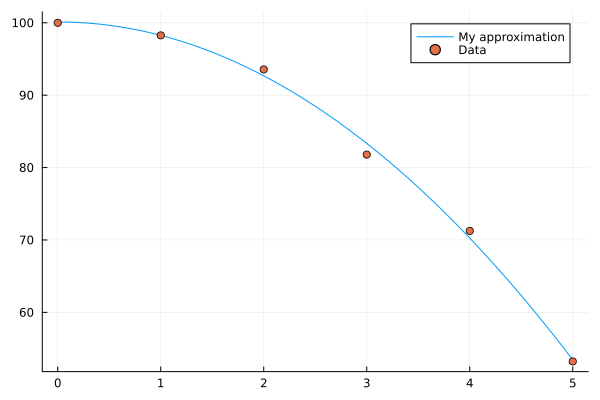

In [6]:
# Time since dropping the marble
x = [0., 1., 2., 3., 4., 5.]

# Altitude of the marble
y = [100., 98.26, 93.56, 81.79, 71.25, 53.22]

# Fit using polyfit
α = polyfit(x, y, 2)

# Evalutate at X
X = LinRange(0, 5, 200)
Y = polyval(α, X)

plot(X, Y, label="My approximation")
scatter!(x, y, label="Data")

In [7]:
# Modify the planet, in lowercase English, then remove the exception
planet = "earth"
### BEGIN SOLUTION
planet = "mars"
### END SOLUTION

"mars"

In [8]:
@assert planet != "earth"
### BEGIN HIDDEN TESTS
@assert planet == "mars" || planet == "mercury"
### END HIDDEN TESTS

   <details>
       <summary>
           <em><font color='gray'>Least squares approximation using `Polynomials.fit` (click to display)</font></em>
       </summary>

   We saw in the previous class that `Polynomials.fit` could be employed for
   polynomial interpolation. This function also be used for fitting
   data by minimizing the sum of squared residuals,
   which can be achieved as follows:
   </details>

p = Polynomial(100.11035714285717 + 0.02374999999997361*x - 1.8716071428571388*x^2)
p.coeffs = [100.11035714285717, 0.02374999999997361, -1.8716071428571388]
p(0) = 100.11035714285717


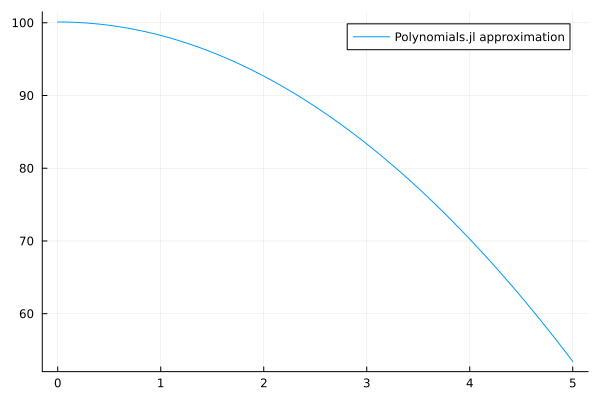

In [9]:
# This returns structure of type `Polynomial`, with associated degree 2
p = fit(x, y, 2)
@show p

# The coefficients can be obtained as follows
@show p.coeffs

# The structure `p` behaves like a function
@show p(0)

X = LinRange(0, 5, 200)
plot(X, p.(X), label="Polynomials.jl approximation")

### <font color='green'>Direct methods</font>

#### <font color='orange'>[Exercise 2]</font> LU decomposition without Gaussian elimination

L'objectif de cet exercice est de proposer un algorithme permettant de réaliser la décomposition LU d'une matrice réelle $\mathsf{A}\in\mathbb{R}^{n×n}$,
**non pas par élimination gaussienne** mais par identification des entrées de $\mathsf A$ avec celles de $\mathsf L \mathsf U$.
Il s'agit de trouver un matrice triangulaire inférieure $\mathsf L$ formée de 1 sur la diagonale
et une matrice triangulaire supérieure $\mathsf U$ telles que :
<a id="LU"></a>
$$
\tag{LU}
\mathsf{A}=\mathsf{L}\mathsf{U}
$$

1. Écrire une fonction `my_lu(A)` qui prend comme argument une matrice `A` et qui renvoie les matrices `L` et `U`.
   Pour calculer ces matrices, s'appuyer sur une identification successive des éléments des deux membres de <a href="#LU">(LU)</a>,
   ligne par ligne de haut en bas, et de gauche à droite au sein de chaque ligne.

   <details>
       <summary>
           <em><font color='gray'>Hint (click to display)</font></em>
       </summary>

   Lorsqu'on suit l'ordre conseillé,
   la comparaison de l'élément $(i, j)$ fournit une équation pour $\ell_{ij}$ si $j < i$,
   et une équation pour $u_{ij}$ si $j \geq i$.
   Notons qu'il est possible de parcourir les éléments dans d'autres ordres.
   </details>

In [10]:
function my_lu(A)
    ### BEGIN SOLUTION
    n = size(A, 1)
    L, U = zeros(n, n), zeros(n, n)
    for i in 1:n, j in 1:i
        U[j, i] = A[j, i] - L[j, 1:j-1]'U[1:j-1, i]
        L[i, j] = (A[i, j] - L[i, 1:j-1]'U[1:j-1, j]) / U[j, j]
    end
    ### END SOLUTION
    return L, U
end;

In [11]:
ref_lu(A) = LinearAlgebra.lu(A, NoPivot())
@assert my_lu(diagm([1; 2; 3])) == (diagm([1; 1; 1]), diagm([1; 2; 3]))
@assert my_lu([2 -1 0; -1 2 -1; 0 -1 2])[1] ≈ [1 0 0; -1/2 1 0; 0 -2/3 1]
@assert my_lu([2 -1 0; -1 2 -1; 0 -1 2])[2] ≈ [2 -1 0; 0 3/2 -1; 0 0 4/3]
@assert (C = [1 2 3 4; 4 3 2 1; 1 2 1 2; 1 5 4 1]; my_lu(C)[1] ≈ ref_lu(C).L)
@assert (C = [1 2 3 4; 4 3 2 1; 1 2 1 2; 1 5 4 1]; my_lu(C)[2] ≈ ref_lu(C).U)
@assert (C = randn(100, 100); my_lu(C)[1] ≈ ref_lu(C).L)
@assert (C = randn(100, 100); my_lu(C)[2] ≈ ref_lu(C).U)

2. On suppose maintenant que la matrice réelle définie positive `A` est à largeur de bande `b` supposée beaucoup plus petite que `n`.
   Réécrire la fonction de décomposition LU en exploitant la largeur de bande.

   <details>
       <summary>
           <em><font color='gray'>Hint (click to display)</font></em>
       </summary>

   Pour rappel, la largeur de bande est le plus petit nombre naturel $b$ tel que $a_{ij} = 0$ pour tout $i,j \in \{1, \dots, n\}$ tels que $|i-j| > b$.
   </details>

In [12]:
function my_banded_lu(A, b)
    ### BEGIN SOLUTION
    n = size(A, 1)
    L, U = zeros(n, n), zeros(n, n)
    for i in 1:n, j in max(1, i-b):i
        U[j, i] = A[j, i] - L[j, max(j-b, 1):j-1]'U[max(j-b, 1):j-1, i]
        L[i, j] = (A[i, j] - L[i, max(j-b, 1):j-1]'U[max(j-b, 1):j-1, j]) / U[j, j]
    end
    ### END SOLUTION
    return L, U
end;

In [13]:
@assert begin C = randn(100, 100); my_banded_lu(C, 99)[1] ≈ ref_lu(C).L end
@assert begin C = randn(100, 100); my_banded_lu(C, 99)[2] ≈ ref_lu(C).U end

### BEGIN HIDDEN TESTS
_generate_banded(n, b) = [abs(i - j) ≤ b ? randn() : 0. for i in 1:n, j in 1:n]
@assert (C = _generate_banded(10, 2); my_banded_lu(C, 2)[1] ≈ ref_lu(C).L)
@assert (C = _generate_banded(10, 2); my_banded_lu(C, 2)[2] ≈ ref_lu(C).U)
@assert (C = _generate_banded(10, 3); my_banded_lu(C, 3)[1] ≈ ref_lu(C).L)
@assert (C = _generate_banded(10, 3); my_banded_lu(C, 3)[2] ≈ ref_lu(C).U)
@assert (C = _generate_banded(1000, 1); my_banded_lu(C, 1)[1] ≈ ref_lu(C).L)
@assert (C = _generate_banded(1000, 1); my_banded_lu(C, 1)[2] ≈ ref_lu(C).U)
### END HIDDEN TESTS

3. Construire une fonction `generate_banded(n, b)` permettant de générer une matrice carrée aléatoire de taille `n` à largeur de bande donnée `b`.

In [14]:
function generate_banded(n, b)
    ### BEGIN SOLUTION
    A = zeros(n, n)
    for i in 1:n
        for j in max(1, i-b):min(n, i+b)
            A[i, j] = randn()
        end
    end
    return A
    ### END SOLUTION
end;

In [15]:
@assert generate_banded(10, 2)[1, 5] == 0
@assert generate_banded(10, 2)[2, 5] == 0
@assert generate_banded(10, 2)[3, 5] != 0
@assert generate_banded(10, 2)[4, 5] != 0
@assert generate_banded(10, 2)[5, 5] != 0
@assert generate_banded(10, 2)[6, 5] != 0
@assert generate_banded(10, 2)[7, 5] != 0
@assert generate_banded(10, 2)[8, 5] == 0
@assert generate_banded(10, 2)[9, 5] == 0

4. En utilisant `generate_banded`, tester votre implémentation de `my_banded_lu`,
   pour `n = 100` et des valeurs de `b` égales à 2, 3 et 10.
   <details>
       <summary>
           <em><font color='gray'>Hint (click to display)</font></em>
       </summary>

   Vous pouvez utiliser la fonction `lu` de la bibliothèque `LinearAlgebra`,
   avec l'argument `NoPivot()`, correspondant à la fonnction `ref_lu` définie ci-dessus,
   comme fonction de référence.
   Vous pouvez également utiliser la macro `@assert` pour vos tests.
   </details>

In [16]:
### BEGIN SOLUTION
# See hidden tests above
### END SOLUTION

### <font color='green'>Basic iterative methods</font>

#### <font color='orange'>[Exercise 3]</font> Richardson's iteration

Considérer le système linéaire suivant:
$$
    \mathsf A \mathbf x :=
    \begin{pmatrix}
        3 & 1 \\ 1 & 3
    \end{pmatrix}
    \begin{pmatrix}
        x_1 \\
        x_2
    \end{pmatrix}
    =
    \begin{pmatrix}
        11 \\
        9
    \end{pmatrix} =: \mathbf b.
$$

 1. Illustrer à l'aide de la fonction `Plots.contourf` les lignes de niveau de la fonction
 $$
     f(\mathbf x) = \frac{1}{2} \mathbf x^T \mathsf A \mathbf x - \mathbf b^T \mathbf x.
 $$

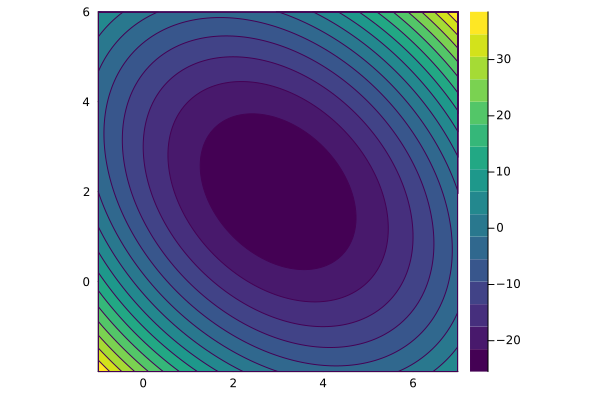

In [17]:
A = [3. 1.; 1. 3.]
b = [11.; 9.]
sol = A\b

### BEGIN SOLUTION
ℓ, nplot = 4, 100
xplot = sol[1] .+ LinRange(-ℓ, ℓ, nplot)
yplot = sol[2] .+ LinRange(-ℓ, ℓ, nplot)

plot(aspect_ratio=:equal)
plot!(xlims=xplot[[1,end]], ylims=yplot[[1,end]], legend=:none)
contourf!(xplot, yplot, (x₁, x₂) -> [x₁; x₂]'A*[x₁; x₂]/2 - b'*[x₁; x₂], c=:viridis)
### END SOLUTION

 2. Implémenter l'itération de Richardson avec $\omega = 0.1$ pour résoudre le système.
    Votre fonction devra renvoyer une liste contenant toutes les itérations.
    Initialiser l'algorithme à $\mathbf x = 0$ et,
    comme critère d'arrêt, utiliser
    $$
    \lVert \mathsf A \mathbf x - \mathbf b \lVert \leq \varepsilon \lVert \mathbf b \lVert, \qquad \varepsilon = 10^{-50}
    $$
    <details>
        <summary>
            <em><font color='gray'>Hint (click to display)</font></em>
        </summary>

    Pour ajouter un élément à la fin d'une liste,
    utiliser la fonction `push!`:

    ```julia
    push!(xs, x)  # Adds x at the end of xs
    ```
    </details>

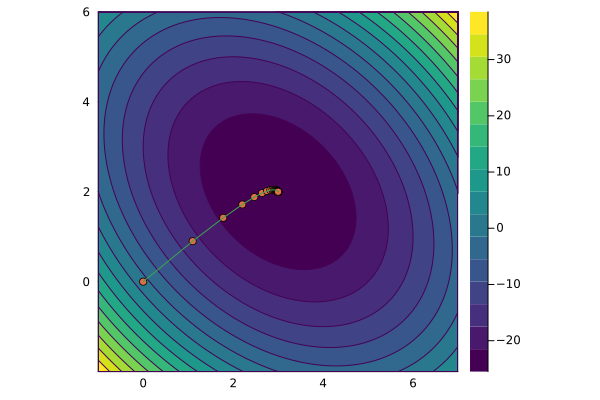

In [18]:
function richardson(ω)
    ε = 1e-50
    x = zeros(BigFloat, 2)
    xs = [x]
    # BEGIN SOLUTION
    while norm(A*x - b)/norm(b) ≥ ε
        x -= ω*(A*x - b)
        push!(xs, x)
    end
    # END SOLUTION
    return xs
end

ω = .1
xs = richardson(ω)
scatter!(eachrow(hcat(xs...))...)
plot!(eachrow(hcat(xs...))...)

 3. Faire un plot de la norme du résidu $\lVert r_k \rVert := \lVert \mathsf A \mathbf x^{(k)} - \mathbf b \rVert$ en fonction de $k$,
    en utilisant une échelle linéaire pour l'axe des abcisses et une échelle logarithmique pour l'axe des ordonnées,
    gràce à l'argument `yscale=:log` passé à la fonction `Plots.plot`.

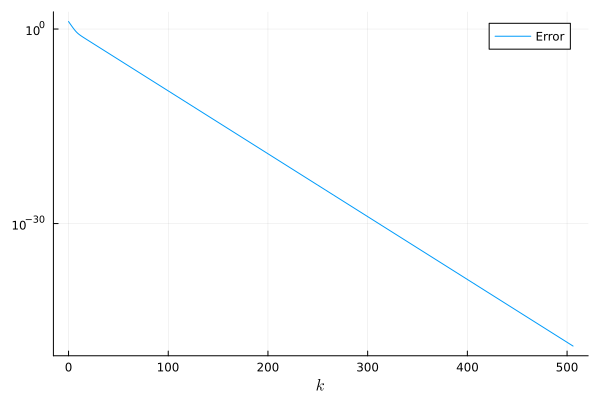

In [19]:
### BEGIN SOLUTION
errors = [norm(A*x - b) for x in xs]
plot(0:length(xs) - 1, errors, label="Error")
plot!(yscale=:log, xlabel=L"k")
### END SOLUTION

 4. En utilisant `Polynomials.fit`, calculer une approximation du type
    $$
    \log(r_k) \approx α + βk \qquad \Leftrightarrow \qquad r_k \approx \exp(α) \times \exp(β)^k.
    $$
    Comparer la valeur de $\exp(β)$ au rayon spectral $\rho(\mathsf I - \omega \mathsf A)$.

In [20]:
# Define β and ρ below
### BEGIN SOLUTION
p = fit(1:length(errors), log.(errors), 1)
β = p[1]  # p[1] == p.coeffs[2]
λs = eigvals(A)
ρ = maximum(abs.(1 .- ω*λs))
### END SOLUTION

exp(β), ρ

(0.7997825113938985902912009059015771785038565910611528260786746665011047405987195, 0.8)

5. Calculer le paramètre $\omega$ optimal et refaire le plot de la décroissance de la norme du résidu dans ce cas.

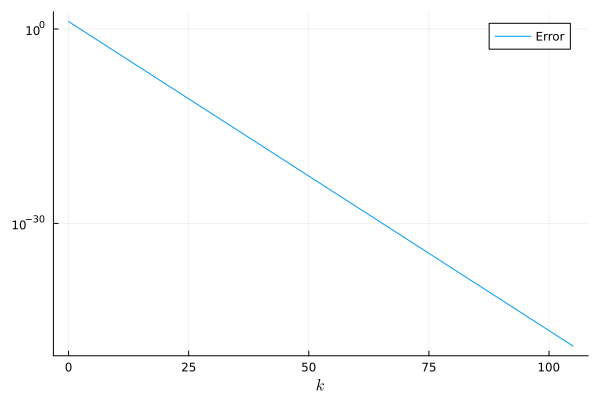

In [21]:
### BEGIN SOLUTION
ω = 2 / (minimum(λs) + maximum(λs))
xs = richardson(ω)
errors = [norm(A*x - b) for x in xs]
plot(yscale=:log, xlabel=L"k")
plot!(0:length(xs) - 1, errors, label="Error")
### END SOLUTION

### <font color='green'>La méthode des gradients conjugués</font>

On considère un système linéaire de la forme
$$
\tag{*} \mathsf A \mathbf x = \mathbf b,
$$
<span id="system"></span>
où $\mathsf A \in \mathbb R^{n\times n}$ est une matrice symétrique définie positive.
On note $\mathbf x_*$ la solution exacte du système.
L'objectif de cet exercice est de dériver théoriquement puis implémenter la *méthode des gradients conjugués*.
Afin de se concentrer sur la seconde partie,
les solutions de la première partie sont données.

#### <font color='orange'>[Exercise 4a]</font> Dérivation théorique de la méthode

On suppose qu'un vecteur $\mathbf x_0$ est donné et on définit, pour $k \in \mathbb N$,
l'espace de Krylov
$$
\mathcal K_k := \text{Span} \Bigl\{ \mathbf r_0, \mathsf A \mathbf r_0, \mathsf A^2 \mathbf r_0, \dotsc, \mathsf A^{k-1} \mathbf r_0 \Bigr\},
\qquad \mathbf r_0 := \mathsf A \mathbf x_0 - \mathbf b.
$$
Soit $\mathbf x_k$ le minimiseur de $f$ sur l'espace affine $\mathbf x_0 + \mathcal K_k$,
où $f$ est la fonction
$$
f(\mathbf x) := \frac{1}{2} \mathbf x^T \mathsf A \mathbf x - \mathbf b^T \mathbf x.
$$
Rappelons que le vecteur $\mathbf x_*$ est minimiseur global de cette fonction strictement convexe.
Le but de cet exercice est de motiver la *méthode des gradients conjugés*, 
qui peut être vue comme une formule de récurence simple pour construire les $\mathbf x_k$ de manière itérative.
Pour ce faire, nous allons suivre les étapes suivantes :


1. Montrer qu'il existe $k_* \in \{0, \dotsc, n\}$ tel que $\mathbf x_k = \mathbf x_*$ pour tout $k \geq k_*$.

   <details>
       <summary>
           <em><font color='blue'>Solution (click to display)</font></em>
       </summary>

   - La suite des sous-espaces $\{\mathcal K_k\}$ est croissante et ces sous-espaces sont de dimension au plus $n$,
     donc il existe $k_* \in \{0, \dotsc, n\}$ tel que $\mathcal K_{k_* + 1} = \mathcal K_{k_*}$.
     En particulier $\mathsf A \mathcal K_{k_*} \subset \mathcal K_{k_*}$.

   - Comme $\mathsf A$ est inversible,
     les deux sous-espaces $\mathsf A \mathcal K_{k_*}$ et $\mathcal K_{k_*}$ sont de même dimension.
     Par conséquent, l'inclusion $\mathsf A \mathcal K_{k_*} \subset \mathcal K_{k_*}$
     implique qu'en fait $\mathsf A \mathcal K_{k_*} = \mathcal K_{k_*}$.

   - En particulier $\mathbf r_0 \in \mathsf A \mathcal K_{k_*}$,
     donc il existe $\mathbf z_* \in \mathcal K_{k_*}$ tel que $\mathsf A \mathbf z_* = -\mathbf r_0$.

   - On conclut car alors $\mathsf A (\mathbf x_0 + \mathbf z_*) = \mathbf b$,
     et donc $\mathbf x_* = \mathbf x_0 + \mathbf z_*$
     appartient à l'espace affine $\mathbf x_0 + \mathcal K_{k_*}$.
   </details>
   <br>
2. Montrer que
   $f(\mathbf x) = \frac{1}{2} \lVert \mathbf x - \mathbf x_* \lVert_{\mathsf A}^2 + f(\mathbf x_*)$,
   où $\langle \mathbf x, \mathbf y \rangle_{\mathsf A} := \mathbf x^T \mathsf A \mathbf y$
   et $\lVert \cdot \rVert_{\mathsf A}$ est la norme associée.

   <details>
       <summary>
           <em><font color='gray'>Remarque (click to display)</font></em>
       </summary>

   Ce point implique que $\mathbf x_k - \mathbf x_0$ est la projection $\mathsf A$-orthogonale de $\mathbf x_* - \mathbf x_0$ sur $\mathcal K_k$.
   </details>
   <br>
3. Soit $\mathbf r_k := \mathsf A \mathbf x_k - \mathbf b.$
   Montrer que $\mathbf r_k = \mathbf r_0 + \mathsf A (\mathbf x_k - \mathbf x_0)$,
   et en déduire que $\mathbf r_k \in \mathcal K_{k+1}$.

4. Montrer que $\langle \mathbf r_{k}, \mathbf v \rangle = 0$ pour tout $\mathbf v \in \mathcal K_{k}.$

   <details>
       <summary>
           <em><font color='blue'>Solution (click to display)</font></em>
       </summary>

   Noter que
   $$
       f(\mathbf x_k + \varepsilon \mathbf v) = \frac{1}{2} \lVert \mathbf x_k - \mathbf x_* \lVert_{\mathsf A}^2 + \varepsilon \langle \mathbf x_k - \mathbf x_*, \mathbf v \rangle_{\mathsf A} + \frac{\varepsilon^2}{2} \lVert \mathbf v \lVert_{\mathsf A}^2 + f(\mathbf x_*).
   $$
   Par définition de $\mathbf x_k$, cette expression est minimale pour $\varepsilon = 0$.
   En imposant que la dérivée par rapport à $\varepsilon$ du membre de droite soit égale à 0 pour $\varepsilon = 0$,
   on obtient $\langle \mathbf x_k - \mathbf x_*, \mathbf v \rangle_{\mathsf A} = 0,$
   ce qui permet de conclure car $\langle \mathbf x_k - \mathbf x_*, \mathbf v \rangle_{\mathsf A} = \langle \mathbf r_{k}, \mathbf v \rangle$.

   </details>
   <br>
5. Déduire des deux points précédents que si $\mathbf r_k \neq \mathbf 0$,
   alors $\mathbf r_k \in \mathcal K_{k+1} \setminus \mathcal K_k$.

6. Déduire aussi que $\langle \mathbf r_{k}, \mathbf v \rangle_{\mathsf A} = 0$ pour tout $\mathbf v \in \mathcal K_{k-1}$,
   pour $k \geq 1$.

   <details>
       <summary>
           <em><font color='blue'>Solution (click to display)</font></em>
       </summary>

   C'est clair car $\langle \mathbf r_{k}, \mathbf v \rangle_{\mathsf A} = \langle \mathbf r_{k}, \mathsf A \mathbf v \rangle$,
   et $\mathsf A \mathbf v \in \mathcal K_{k}$ pour tout $\mathbf v \in \mathcal K_{k-1}$, par définition des espaces de Krylov $\{\mathcal K_k\}$.
   </details>
   <br>

7. Conclure que, pour tout $k$ tel que $\mathbf r_k \neq \mathbf 0$,
   les vecteurs $(\mathbf d_0, \dotsc, \mathbf d_k)$ définis par la relation de récurrence
   $$
   \tag{CG1}
   \mathbf d_{\ell} = \mathbf r_{\ell} - \frac{\mathbf r_{\ell}^T \mathsf A \mathbf d_{\ell-1}}{\mathbf d_{\ell-1}^T \mathsf A \mathbf d_{\ell-1}} \mathbf d_{\ell-1},
   \qquad \mathbf d_0 = \mathbf r_0
   $$
   <span id="CG1"></span>
   forment une base $\mathsf A$-orthogonale de $\mathcal K_{k+1}$.

   <details>
       <summary>
           <em><font color='blue'>Solution (click to display)</font></em>
       </summary>

   La propriété est trivialement vérifiée pour $k = 0$.
   Prenons maintenant $k > 0$ et supposons par récurrence que $(\mathbf d_0, \dotsc, \mathbf d_{k-1})$ forment une base $\mathsf A$-orthogonale de $\mathcal K_k$.
   Par construction $\left\langle \mathbf d_k, \mathbf d_{k-1} \right\rangle_{\mathsf A} = 0$.
   On a aussi que $\left\langle \mathbf d_k, \mathbf d_{\ell} \right\rangle_{\mathsf A} = 0$ pour tout $\ell \in \{0, \dotsc, k-2\}$,
   car on a montré précédemment que $\langle \mathbf r_k, \mathbf v \rangle_{\mathsf A} = 0$ pour tout $\mathbf v \in \mathcal K_{k-1}$.
   </details>
   <br>

8. Montrer que $\mathbf x_{k+1} - \mathbf x_{k}$ est $\mathsf A$-orthogonal à $\mathcal K_k$,
   d'où $\mathbf x_{k+1} = \mathbf x_{k} - \omega_k \mathbf d_k$ pour un $\omega_k \in \mathbb R$ quand $\mathbf r_k \neq 0$.

   <details>
       <summary>
           <em><font color='blue'>Solution (click to display)</font></em>
       </summary>

   Noter que $\langle \mathbf x_{k+1} - \mathbf x_k, \mathbf v \rangle_{\mathsf A} = \langle \mathbf r_{k+1} - \mathbf r_k, \mathbf v \rangle$,
   et utiliser un des résultats prouvés ci-dessus.
   </details>
   <br>

9. Pour terminer, montrer que
   $$
   \tag{CG2}
   \mathbf x_{k+1} = \mathbf x_k - \frac{\mathbf r_k^T \mathbf d_k}{\mathbf d_k^T \mathsf A \mathbf d_k} \mathbf d_k.
   $$
   <span id="CG1"></span>

   <details>
       <summary>
           <em><font color='blue'>Solution (click to display)</font></em>
       </summary>

   Il suffit de trouver le paramètre $\omega_k$ du point précédent par minimisation de $f(\mathbf x_k - \omega_k \mathbf d_k)$.
   </details>

#### <font color='orange'>[Exercise 4b]</font> Implémentation de la méthode
 Les relations <a href="#CG1">(CG1)</a> et <a href="#CG2">(CG2)</a> permettent de construire les vecteurs $(\mathbf x_k)$ de manière récursive,
 à un coût par itération indépendent de $k$; c'est la méthode des **gradients conjugués**.

 - Sur base de ces équations,
   implémenter une fonction Julia pour résoudre le système <a href="#system">(*)</a>.
   Votre fonction devra renvoyer un vecteur de vecteur (de type `Vector{Vector{Float64}}`)
   contenant toutes les itérations $(\mathbf x_0, \mathbf x_1, \dotsc, \mathbf x_K)$.
   Utiliser comme vecteur initial $\mathbf x_0$ un vecteur de 1,
   qui pourra être construit en utilisant la fonction `ones`.
   Comme critère d'arrêt, utiliser la condition
   $$
   \lVert \mathsf A \mathbf x_k - \mathbf b \rVert 
   \leq ε \lVert \mathbf b \rVert.
   $$

In [22]:
function conjugate_gradients(A, b; ε=1e-10)
    ### BEGIN SOLUTION
    n = length(b)
    x = ones(n)
    d = r = A*x - b
    xs = [x]
    while √(r'r) ≥ ε * √(b'b)
        ω = d'r / (d'A*d)
        x -= ω*d
        r = A*x - b
        β = r'A*d/(d'A*d)
        d = r - β*d
        push!(xs, x)
    end
    xs
    ### END SOLUTION
end;

In [23]:
@assert typeof(conjugate_gradients([1. 0.; 0. 1.], [2.; 3.])) == Vector{Vector{Float64}}
@assert conjugate_gradients([1. 0.; 0. 1.], [2.; 3.])[end] ≈ [2.; 3.]
@assert conjugate_gradients([2. 1.; 1. 2.], [3.; 3.])[end] ≈ [1.; 1.]
@assert conjugate_gradients([4. 1. 0.; 1. 4. 1.; 0. 1. 4.], [4.; 1.; 0.])[end] ≈ [1.; 0.; 0.]

 - Tester votre implémentation sur la matrice $\mathsf A$ et le vecteur $\mathbf b$ du code ci-dessous,
   qui correspondent à une discrétisation par différences finies de l'équation de Poisson sur le domaine $\Omega = (0, 2) \times (0, 1)$,
   avec condition de Dirichlet homogène à la frontière:
   $$
   \begin{aligned}
       - \Delta u(x, y) &= b(x, y), \qquad (x, y) \in \Omega, \\
       u(x, y) &= 0, \quad \qquad \quad (x, y) \in \partial \Omega.
   \end{aligned}
   $$
   Le membre de droite qu'on prend est
   $$
      b(x, y) = \sin(4\pi x) + \sin(2\pi y).
   $$

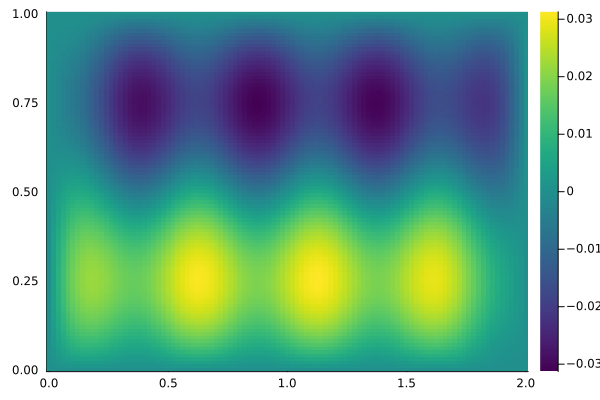

In [24]:
using LaTeXStrings
using LinearAlgebra
using Plots
import SparseArrays

# Domain size
Lx, Ly = 2, 1

# Number of discretization points along x and y, including the boundary points
nx, ny = 101, 101

function discretize(nx, ny)
    hx, hy = Lx/(nx - 1), Ly/(ny - 1)
    Dxx = (1/hx^2) * SymTridiagonal(2ones(nx-2), -ones(nx-3))
    Dyy = (1/hy^2) * SymTridiagonal(2ones(ny-2), -ones(ny-3))
    A = kron(Dxx, I(ny-2)) + kron(I(nx-2), Dyy)
    xgrid = Lx/(nx-1) * (1:nx-2)
    ygrid = Ly/(ny-1) * (1:ny-2)
    x_2d = reshape([x for y in ygrid, x in xgrid], (nx-2)*(ny-2))
    y_2d = reshape([y for y in ygrid, x in xgrid], (nx-2)*(ny-2))
    b = sin.(4π*x_2d) + sin.(2π*y_2d)
    return SparseArrays.SparseMatrixCSC(A), b
end

function plot_solution(f)
    f = reshape(f, ny-2, nx-2)
    z = [zeros(nx)'; zeros(ny-2) f zeros(ny-2); zeros(nx)']  # Add boundary
    xgrid = Lx/(nx-1) * (0:nx-1)
    ygrid = Ly/(ny-1) * (0:ny-1)
    heatmap(xgrid, ygrid, z, c=:viridis, levels=50)
end

A, b = discretize(nx, ny)
xs = conjugate_gradients(A, b)
x₊ = A\b  # Exact solution
plot_solution(x₊)
plot_solution(xs[end])

 - Faire un graphe illustrant l'évolution du résidu $\lVert \mathbf r_k \rVert$, de l'erreur $\lVert \mathbf x_k - \mathbf x_* \rVert$,
   et de l'erreur $\lVert \mathbf x_k - \mathbf x_* \rVert_{\mathsf A}$ en fonction de $k$.
   Choisissez des échelles appropriées pour le graphe (linéaire-linéaire, log-log, linéaire-log ou log-linéaire).

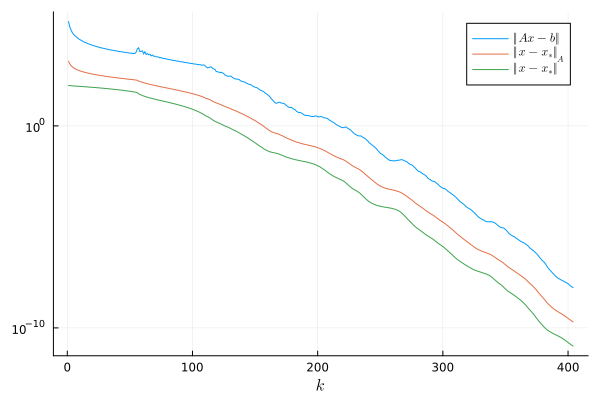

In [25]:
### BEGIN SOLUTION
rs = [A*x - b for x in xs]
es = [x - x₊ for x in xs]
plot(xlabel=L"k", yaxis=:log)
plot!([√(r'r) for r in rs], label=L"\Vert Ax - b \Vert")
plot!([√(e'r) for (e, r) in zip(es, rs)], label=L"\Vert x - x_{*} \Vert_A")
plot!([√(e'e) for e in es], label=L"\Vert x - x_{*} \Vert")
### END SOLUTION